# DoorDash Merchant Operations Analytics Project
## Name: Jia Wen (Steven) Liu
## Date: 2021-07-16

In [1]:
# Import relevant libraries for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm
import scipy.stats as ss

# Project Goal: Provide a set of recommendations on how to improve DoorDash with provided sample delivery data

### Business Recommendations:
 - Utilize time-region based switchback testing to understand how many drivers are needed at each region at different hours of the day to maximize orders amount and revenue while minimizing the total delivery times. This would provide a better control of network equiliribum between each participant and further optimize the metrics for DoorDash.
 
 - Increase the number of drivers or driver tips at each region (Mountain View, Palo Alto, and San Jose) at peak-hours to reduce the average of amount of orders per hour, average total time to customers, and less congestion for the ordering traffic. This may provide higher customer, merchant, and drivers experience overall, which leads to better experiences and branding for DoorDash that could drive up market share percentage.
 
 - Collabrate with the merchants to increase their average order total amount for each order by providing a tier-based reward incentive system. The tier-based reward incentive system could be based on customer-merchant time-diff, merchant-driver time-diff, and total delivery time. The lower the time-diffs are, the higher tiers/incentives the merchants are eligible for. By incorporating the merchants in the entire supply chain system with incentives, the merchants are more likely be execute the orders more efficiently and more responsibly. This would provide a higher revenue to DoorDash while providing a win-win siutation to the merchants.
 
 - Establish a more robust system to encourage customers to use scheduled orders (is ASAP=False). This allows for better prepartion and relieve the supply chain and logistic burdens on all participants (merchants, drivers and DoorDash). From the t-test shown in Part F, customers spend more on orders on average with scheduled orders. This would provide a higher revenue to DoorDash while providing a win-win situation to merchants. 
 
 - Perform location/geographical-based clustering algorithm on Restaurant ID in each region based on Order Total. This would further allow DoorDash to understand popular neighborhoods and businesses that customers frequently order from. DoorDash can plan drivers route more accurately based on these clusters and traffic. Additionally, DoorDash should leverage this data to promote and work with local merchants/businesses that are not frequently ordered by the customers. This helps the improve the DoorDash relationship with the local businesses and helping them out. Actions could be working with the advertising, sales, and marketing team to promote those businesses with highlights or discounts on DoorDash.
 
 - Perform A/B or A/A testing to understand how much discounts are needed to see a positive impact on the order total for each restaurant.

## Part A: Data Cleaning
Using the 'Sample deliveries data - 1 month.xlsx', perform exploratory data analysis and data cleaning. The plan is to：
 - Convert the first four datetime columns into Datetime object. Assume the data is in the month of 2014 January for easier computation of time difference and timezone conversion because DoorDash founding date is in the early 2013. This assumption does not impact further analysis in this notebook.
 - Convert UTC timezone to PT timezone.
 - Check for missing values for each feature column. Either drop missing values or perform missing value imputation.

In [2]:
# Genereated from the provided 'Sample deliveries data - 1 month' file
# Store provided data in dataframe for ease of access
file_name = 'Sample deliveries data - 1 month.xlsx'
deliveries_data = pd.read_excel(file_name)

C:\Users\Steven\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [3]:
deliveries_data.head()

,Customer placed order datetime,Placed order with restaurant datetime,Driver at restaurant datetime,Delivered to consumer datetime,Driver ID,Restaurant ID,Consumer ID,Delivery Region,Is ASAP,Order total,Amount of discount,Amount of tip,Refunded amount
0,01 02:52:12,01 03:00:25,01 03:08:09,01 03:35:20,279,50,6738,Mountain View,True,16.33,0.0,0.82,0.0
1,13 15:58:57,13 17:56:45,13 18:24:39,13 18:57:01,303,96,64746,Palo Alto,True,76.14,0.0,6.45,0.0
2,17 19:02:37,17 19:12:51,17 19:19:59,17 19:31:09,212,190,12484,San Jose,True,16.77,6.0,2.52,0.0
3,12 04:01:57,12 04:08:18,12 04:13:02,12 04:37:57,352,194,13920,San Jose,True,25.03,0.0,5.00,0.0
4,08 23:46:38,08 23:49:32,08 23:54:29,09 00:37:15,313,9,7037,Palo Alto,True,51.57,0.0,5.16,0.0


In [4]:
deliveries_data['Customer placed order datetime'] = '2014-01-' + deliveries_data['Customer placed order datetime']
deliveries_data['Placed order with restaurant datetime'] = '2014-01-' + deliveries_data['Placed order with restaurant datetime']
deliveries_data['Driver at restaurant datetime'] = '2014-01-' + deliveries_data['Driver at restaurant datetime']
deliveries_data['Delivered to consumer datetime'] = '2014-01-' + deliveries_data['Delivered to consumer datetime']

deliveries_data.loc[:, 'Customer placed order datetime'] = pd.to_datetime(deliveries_data['Customer placed order datetime'],
            format='%Y-%m-%d %H:%M:%S').dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
deliveries_data.loc[:, 'Placed order with restaurant datetime'] = pd.to_datetime(deliveries_data['Placed order with restaurant datetime'],
            format='%Y-%m-%d %H:%M:%S').dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
deliveries_data.loc[:, 'Driver at restaurant datetime'] = pd.to_datetime(deliveries_data['Driver at restaurant datetime'],
            format='%Y-%m-%d %H:%M:%S').dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
deliveries_data.loc[:, 'Delivered to consumer datetime'] = pd.to_datetime(deliveries_data['Delivered to consumer datetime'],
            format='%Y-%m-%d %H:%M:%S').dt.tz_localize('UTC').dt.tz_convert('US/Pacific')

In [5]:
deliveries_data.info()
deliveries_data.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18078 entries, 0 to 18077
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype                     
---  ------                                 --------------  -----                     
 0   Customer placed order datetime         18078 non-null  datetime64[ns, US/Pacific]
 1   Placed order with restaurant datetime  18038 non-null  datetime64[ns, US/Pacific]
 2   Driver at restaurant datetime          13547 non-null  datetime64[ns, US/Pacific]
 3   Delivered to consumer datetime         18078 non-null  datetime64[ns, US/Pacific]
 4   Driver ID                              18078 non-null  int64                     
 5   Restaurant ID                          18078 non-null  int64                     
 6   Consumer ID                            18078 non-null  int64                     
 7   Delivery Region                        18078 non-null  object                    
 8   Is ASAP         

Customer placed order datetime              0
Placed order with restaurant datetime      40
Driver at restaurant datetime            4531
Delivered to consumer datetime              0
Driver ID                                   0
Restaurant ID                               0
Consumer ID                                 0
Delivery Region                             0
Is ASAP                                     0
Order total                                 0
Amount of discount                          0
Amount of tip                               0
Refunded amount                             0
dtype: int64

There are 40 missing values for 'Placed order with restaurant datetime' (40/18078= 0.22%) and 4531 missing values for 'Driver at restaurant datetime' (4531/18078=25.06%). Due to the large amount of missing values for 'Driver at restaurant datetime' column, the plan is to 
- Drop the missing values for 'Placed order with restaurant datetime'
- Perform missing value imputation for 'Driver at restaurant datetime' by taking the average between 'Placed order with restaurant datetime' and 'Delivered to consumer datetime'.

In [6]:
deliveries_data = deliveries_data.dropna(subset=['Placed order with restaurant datetime'])

In [7]:
deliveries_data[deliveries_data['Driver at restaurant datetime'].isna()]

,Customer placed order datetime,Placed order with restaurant datetime,Driver at restaurant datetime,Delivered to consumer datetime,Driver ID,Restaurant ID,Consumer ID,Delivery Region,Is ASAP,Order total,Amount of discount,Amount of tip,Refunded amount
8,2014-01-13 14:45:41-08:00,2014-01-13 15:22:33-08:00,NaT,2014-01-13 15:49:14-08:00,196,225,2469,Mountain View,False,35.85,0.0,2.00,0.0
11,2014-01-11 20:58:55-08:00,2014-01-11 20:59:31-08:00,NaT,2014-01-11 21:24:01-08:00,36,176,57150,San Jose,True,40.69,0.0,4.78,0.0
13,2014-01-27 08:49:32-08:00,2014-01-27 09:50:50-08:00,NaT,2014-01-27 10:25:00-08:00,343,259,14776,Palo Alto,False,58.09,0.0,2.90,0.0
18,2014-01-12 11:21:54-08:00,2014-01-12 11:25:02-08:00,NaT,2014-01-12 12:32:06-08:00,354,8,5783,Palo Alto,True,27.21,0.0,2.92,0.0
21,2014-01-05 18:32:46-08:00,2014-01-05 18:36:38-08:00,NaT,2014-01-05 19:30:03-08:00,115,53,4339,Palo Alto,True,49.45,0.0,1.99,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18044,2014-01-28 18:29:39-08:00,2014-01-28 18:33:57-08:00,NaT,2014-01-28 19:00:44-08:00,357,96,36970,Palo Alto,True,62.01,0.0,7.72,0.0
18055,2014-01-29 11:11:58-08:00,2014-01-29 11:22:31-08:00,NaT,2014-01-29 11:56:28-08:00,216,3,198226,Palo Alto,True,16.82,6.0,2.00,0.0
18067,2014-01-29 18:17:32-08:00,2014-01-29 18:18:46-08:00,NaT,2014-01-29 18:53:18-08:00,216,20,199347,Palo Alto,True,16.33,6.0,0.82,0.0
18072,2014-01-30 10:05:04-08:00,2014-01-30 10:31:56-08:00,NaT,2014-01-30 11:26:56-08:00,290,347,69857,Mountain View,False,37.38,0.0,1.44,0.0


In [8]:
deliveries_data['Driver at restaurant datetime'] = deliveries_data.apply(lambda row: (row['Delivered to consumer datetime']-row['Placed order with restaurant datetime'])/2+row['Placed order with restaurant datetime'] if pd.isna(row['Driver at restaurant datetime']) else row['Driver at restaurant datetime'], axis=1)

## Part B: Compute for time-difference between customer, merchant, driver, and customer.

Compute the following data and store them in the original deliveries_data dataframe for further analysis.
 - ***Customer-Merchant Time Diff (unit: seconds)***：= Place order with restaurant datetime - Customer placed order date time. It represents the amount of time delay between customer placing the order and restaurant receiving the order.
 - ***Merchant-Driver Time Diff (unit: seconds)***：= Driver at restaurant datetime - Placed order with restaurant datetime. It represents the amount of time delay between restaurant receiving the order and the driver arriving at the restaurant.
 - ***Driver-Consumer Time Diff (unit: seconds)***: = Delivered to consumer datetime - Driver at restaurant datetime. It represents the amount of time delay between the driver arriving at the restaurant and the customer receiving the order. 

In [9]:
deliveries_data['Customer-Merchant time diff'] = (deliveries_data['Placed order with restaurant datetime']
                                                                        - deliveries_data['Customer placed order datetime']).dt.seconds

deliveries_data['Merchant-Driver time diff'] = (deliveries_data['Driver at restaurant datetime']
                                                                        - deliveries_data['Placed order with restaurant datetime']).dt.seconds

deliveries_data['Driver-Consumer time diff'] = (deliveries_data['Delivered to consumer datetime'] 
                                                                        - deliveries_data['Driver at restaurant datetime']).dt.seconds
deliveries_data.head()

,Customer placed order datetime,Placed order with restaurant datetime,Driver at restaurant datetime,Delivered to consumer datetime,Driver ID,Restaurant ID,Consumer ID,Delivery Region,Is ASAP,Order total,Amount of discount,Amount of tip,Refunded amount,Customer-Merchant time diff,Merchant-Driver time diff,Driver-Consumer time diff
0,2013-12-31 18:52:12-08:00,2013-12-31 19:00:25-08:00,2013-12-31 19:08:09-08:00,2013-12-31 19:35:20-08:00,279,50,6738,Mountain View,True,16.33,0.0,0.82,0.0,493,464,1631
1,2014-01-13 07:58:57-08:00,2014-01-13 09:56:45-08:00,2014-01-13 10:24:39-08:00,2014-01-13 10:57:01-08:00,303,96,64746,Palo Alto,True,76.14,0.0,6.45,0.0,7068,1674,1942
2,2014-01-17 11:02:37-08:00,2014-01-17 11:12:51-08:00,2014-01-17 11:19:59-08:00,2014-01-17 11:31:09-08:00,212,190,12484,San Jose,True,16.77,6.0,2.52,0.0,614,428,670
3,2014-01-11 20:01:57-08:00,2014-01-11 20:08:18-08:00,2014-01-11 20:13:02-08:00,2014-01-11 20:37:57-08:00,352,194,13920,San Jose,True,25.03,0.0,5.00,0.0,381,284,1495
4,2014-01-08 15:46:38-08:00,2014-01-08 15:49:32-08:00,2014-01-08 15:54:29-08:00,2014-01-08 16:37:15-08:00,313,9,7037,Palo Alto,True,51.57,0.0,5.16,0.0,174,297,2566


 ## Part C: Number of orders vs Hour of the Day
 ***Discussion:***
 From the 'Number of Orders placed per hour of the day' plot, it shows that the signicant order amounts are placed between 9AM-12PM and 16PM-19PM, which coincides with the time range of lunch and dinner. As a result, it is important to keep in mind that these hours are the peak-hours. Peak-hours create a greater inflow of orders and traffic to all the network members: DoorDash, customers, merchants, and drivers/dashers.

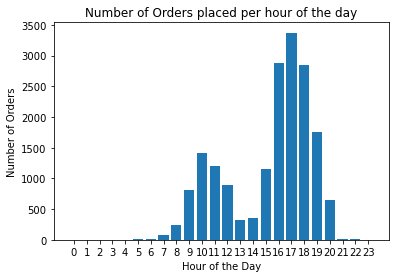

In [10]:
deliveries_data['customer_order_hours'] = deliveries_data['Customer placed order datetime'].dt.hour
num_order_per_hour = deliveries_data.groupby('customer_order_hours').count().iloc[:, 0]

plt.bar(num_order_per_hour.index, num_order_per_hour.values)
plt.title('Number of Orders placed per hour of the day')
plt.ylabel('Number of Orders')
plt.xlabel('Hour of the Day')
plt.xticks(np.arange(min(num_order_per_hour.index),max(num_order_per_hour.index)+1,1))
plt.show()

## Part D: Regional impact on orders and drivers
The goal of this section is to understand if specific regions have any impacts and correlations on the orders and drivers counts per hour. Business recommedations may vary a lot by regions since food delivery can be highly impacted by hyperlocal environment variables, even if the three regions covered in this dataset are all in the same larger geographical area of California.

In [11]:
# Define funcitons to plot
def plot_region_graph(df, title, ylabel):
    plt.plot(df['Mountain View'].index, df['Mountain View'].values, label='Mountain View')
    plt.plot(df['Palo Alto'].index, df['Palo Alto'].values, label='Palo Alto')
    plt.plot(df['San Jose'].index, df['San Jose'].values, label='San Jose')
    plt.legend()
    plt.title(title)
    plt.xlabel('Hour of the Day')
    plt.ylabel(ylabel)
    plt.xticks(np.arange(0,24,1))
    plt.show()

def plot_normalized_region_graph(df1, df2, title, ylabel):
    plt.plot(df1['Mountain View'].index, df1['Mountain View'].values/df2['Mountain View'], label='Mountain View')
    plt.plot(df1['Palo Alto'].index, df1['Palo Alto'].values/df2['Palo Alto'], label='Palo Alto')
    plt.plot(df1['San Jose'].index, df1['San Jose'].values/df2['San Jose'], label='San Jose')
    plt.legend()
    plt.title(title)
    plt.xlabel('Hour of the Day')
    plt.ylabel(ylabel)
    plt.xticks(np.arange(0,24,1))
    plt.show()

***Orders per Hour at Each Region Discussion***:

The trends in Orders count per hour at each region plot are similar to that in the Number of Orders placed per hour of the day plot in Part C. Palo Alto has a siginificantly higher amount of orders per hour at peaks hours than Mountain View and San Jose, indicating that it is a bigger market. 

I further looked into how many unique consumers, restaurants, and drivers are in each region. Although there are a higher number of restaurantsin the San Jose area (155, compared to 148 in Palo Alto and 110 in Mountain View), they have the least number of orders among the three regions. This leads to several business proposals that needs further verification to boost the business in the San Jose area: improvement on the quality of restaurants, and promotions and marketing campaigns to boost conversion for new customers. 

The Normalized Orders per hour is the orders per hour divided by the total order amount at each region. It shows the normalized orders counts per hour are similar for all 3 regions.

Delivery Region
Mountain View     3750
None                21
Palo Alto        11409
San Jose          2858
Name: Customer placed order datetime, dtype: int64


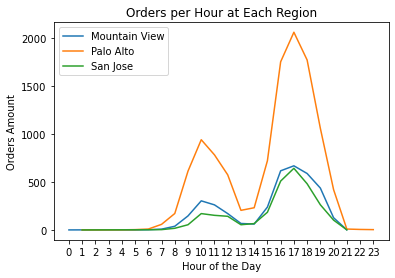

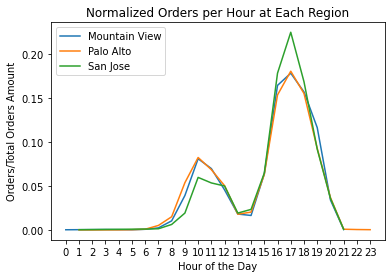

Delivery Region
Mountain View    110
None              12
Palo Alto        148
San Jose         155
Name: Restaurant ID, dtype: int64


In [12]:
# Order count
order_count_df = deliveries_data.groupby(['Delivery Region', 'customer_order_hours']).count().iloc[:, 0]
total_order_count_df = deliveries_data.groupby('Delivery Region').count().iloc[:, 0]
print(total_order_count_df)

plot_region_graph(order_count_df, 'Orders per Hour at Each Region', 'Orders Amount')
plot_normalized_region_graph(order_count_df, total_order_count_df, 'Normalized Orders per Hour at Each Region', 'Orders/Total Orders Amount')

print(deliveries_data.groupby(['Delivery Region']).nunique()['Restaurant ID'])

***Drivers per Hour at Each Region Discussion***:

The drivers count per hour at each region shows they are similar to the 'Number of Orders placed per hour of the day' plot in Part C.

Palo Alto has a siginificantly higher amount of drivers per hour at peaks hours than Mountain View and San Jose. The Normalized Drivers per hour is the drivers per hour divided by the total drivers amount at each region. It shows the normalized orders drivers per hour are similar for all 3 regions.

Delivery Region
Mountain View    134
None               9
Palo Alto        237
San Jose          90
Name: Driver ID, dtype: int64


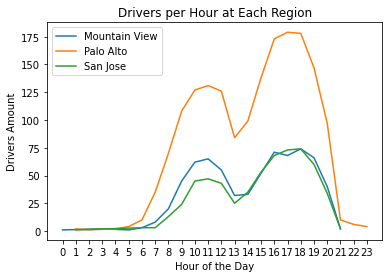

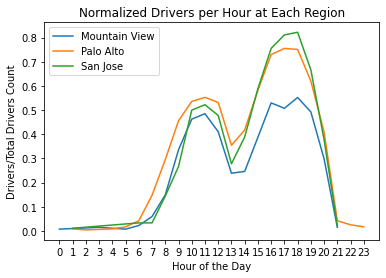

In [13]:
# Driver count
driver_count_df = deliveries_data.groupby(['Delivery Region', 'customer_order_hours']).nunique()['Driver ID']
total_driver_count_df = deliveries_data.groupby('Delivery Region').nunique()['Driver ID']
print(total_driver_count_df)

plot_region_graph(driver_count_df, 'Drivers per Hour at Each Region', 'Drivers Amount')
plot_normalized_region_graph(driver_count_df, total_driver_count_df, 'Normalized Drivers per Hour at Each Region', 'Drivers/Total Drivers Count')

***Average order amount per driver per hour-region***:

The average order count per driver per hour-region region shows they are similar to the 'Number of Orders placed per hour of the day' plot in Part C. Mountain View has a siginificantly higher average order amount per driver per hour at peaks hours than Palo Alot and San Jose. With an estimated of maximium of 12 average orders per driver at peak-hour of 17PM, each driver would have to deliver each order in 5 minutes to the customer.

    - Mountain View: max of average 12 orders per hour per driver with average 5 minutes delivery time to the customers.
    - Palo Alto: max of average 10 orders per hour per driver with average 6 minutes delivery time to the customers.
    - San Jose: max of average 9 orders per hour per driver with average 6.67 minutes delivery time to the customers.
    
Based on these computed metrics, there are too many orders per hour each driver needs to deliver at each region. With the expected average of 5 minutes delivery time, there are many factors like traffic, unexpected delays at the merchants, and other etc. in real life that most likely delay the drivers to deliver the orders successfully within 5 minutes.

In later part of this project, I computed the average delivery time from drivers getting to the merchants until customers getting the orders with 'Driver-Consumer Time Diff' computed in Part B. This would be used to compare to the computed average delivery time in this section.

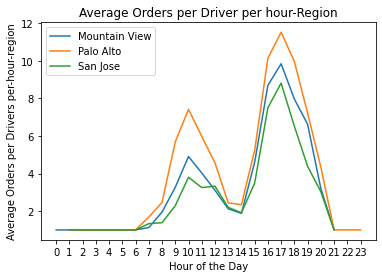

In [14]:
# Average order amount per driver per hour-region
avg_order_per_driver_df = order_count_df / driver_count_df
plot_region_graph(avg_order_per_driver_df, 'Average Orders per Driver per hour-Region', 'Average Orders per Drivers per-hour-region')

***Correlation between Time and region***:
Computed the correlation between total time, Customer-Merchant time diff, Merchant-Driver time diff, Driver-Consumer time diff at reach region for on-demand deliveries (Is ASAP=True). The goal is understand if each of the times has an impact to the order count for each region. With a threshold of p-value of 0.005, the following relations are significant:

   - Total Time at San Jose: corr (78.43%) and p-value(0.004)
   - Customer-Merchant time diff at San Jose: corr (87.6%) and p-value (0.004)
   - Driver-Consumer time diff at Mountain View: corr (63.7%) and p-value (0.048)


In [15]:
deliveries_data['total_time'] = (deliveries_data['Delivered to consumer datetime']
                                                - deliveries_data['Customer placed order datetime']).dt.seconds

for col in ['total_time', 'Customer-Merchant time diff', 'Merchant-Driver time diff', 'Driver-Consumer time diff']:
    print(col)
    for region in ['Mountain View', 'Palo Alto', 'San Jose']:
        print(region)
        print(ss.pearsonr(deliveries_data[deliveries_data['Is ASAP']==True].groupby(['Delivery Region', 'customer_order_hours']).count().iloc[:,0][region].loc[10:20], 
                     deliveries_data[deliveries_data['Is ASAP']==True].groupby(['Delivery Region', 'customer_order_hours']).mean()[col][region].loc[10:20]))
    print('')

total_time
Mountain View
(0.6455699582340158, 0.043792976590208685)
Palo Alto
(0.48499914185215814, 0.13051635148615318)
San Jose
(0.7842945348691469, 0.004265603761576214)

Customer-Merchant time diff
Mountain View
(0.35320833534094936, 0.31674777264775705)
Palo Alto
(0.05019960429690061, 0.8834677709883043)
San Jose
(0.8755462210721865, 0.0004127718592269526)

Merchant-Driver time diff
Mountain View
(-0.16565190735657945, 0.647417266526263)
Palo Alto
(0.07802902303182761, 0.8196166497044405)
San Jose
(-0.12344149940457094, 0.717653455892287)

Driver-Consumer time diff
Mountain View
(0.6369353706324388, 0.047648707378568564)
Palo Alto
(0.05435817603528598, 0.8738780930268607)
San Jose
(0.3659147440133548, 0.2684193809655844)



## Part E: Time-Diff per hour of the day
Examine the total time, Customer-Merchant time diff, Merchant-Driver time diff, Driver-Consumer time diff per hour of teh day. The goal is to understand what are the average times for each time-diff and come up with business recommendations to improve business.

Looking at the is_ASAP table below, there is a big difference between on-demand and scheduled orders for total time from customer placing the order and receiving the orders and the Customer-Merchant time diff. As a reuslt, my assumption is to only use on-demand orders to compute the time-diff per hour of the day in the this section.

In [16]:
deliveries_data.groupby('Is ASAP').mean()[['total_time', 'Customer-Merchant time diff', 'Merchant-Driver time diff', 'Driver-Consumer time diff']]

,total_time,Customer-Merchant time diff,Merchant-Driver time diff,Driver-Consumer time diff
Is ASAP,,,,
False,9339.185576,6447.533426,2439.833564,1530.191401
True,2801.389039,437.395829,1525.971662,1424.553592


Average customer-merchant order time difference from 7AM-9PM: 1369.239478023042 seconds or 22.8206579670507 minutes
Average customer-merchant order time difference from 10AM-9PM: 373.1743475288024 seconds or 6.219572458813373 minutes


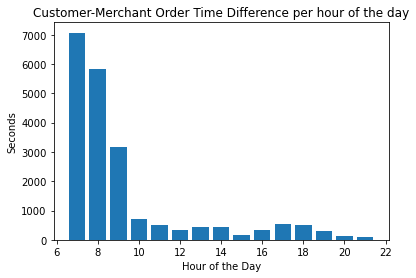

In [17]:
deliveries_data_is_asap_df = deliveries_data[deliveries_data['Is ASAP']==True]
cust_merch_timediff_per_hour = deliveries_data_is_asap_df.groupby('customer_order_hours').mean()['Customer-Merchant time diff']

print('Average customer-merchant order time difference from 7AM-9PM:', cust_merch_timediff_per_hour.loc[7:21].mean(), 'seconds or',cust_merch_timediff_per_hour.loc[7:21].mean()/60,'minutes')
print('Average customer-merchant order time difference from 10AM-9PM:', cust_merch_timediff_per_hour.loc[10:21].mean(), 'seconds or',cust_merch_timediff_per_hour.loc[10:21].mean()/60,'minutes')

plt.bar(cust_merch_timediff_per_hour.index, cust_merch_timediff_per_hour)
plt.title('Customer-Merchant Order Time Difference per hour of the day')
plt.ylabel('Seconds')
plt.xlabel('Hour of the Day')
plt.show()

Average merchant-driver order time difference from 7AM-8PM: 1493.8625536154602 seconds or 24.897709226924338 minutes


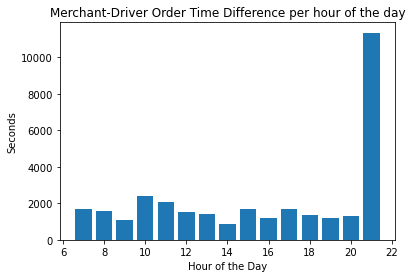

In [18]:
merch_driver_timediff_per_hour = deliveries_data_is_asap_df.groupby('customer_order_hours').mean()['Merchant-Driver time diff']
print('Average merchant-driver order time difference from 7AM-8PM:', merch_driver_timediff_per_hour.loc[7:20].mean(), 'seconds or', merch_driver_timediff_per_hour.loc[7:20].mean()/60,'minutes')

plt.bar(merch_driver_timediff_per_hour.index, merch_driver_timediff_per_hour)
plt.title('Merchant-Driver Order Time Difference per hour of the day')
plt.ylabel('Seconds')
plt.xlabel('Hour of the Day')
plt.show()

Average driver-consumer delivery time difference from 7AM-8PM: 1558.113389574523 seconds or 25.968556492908714 minutes


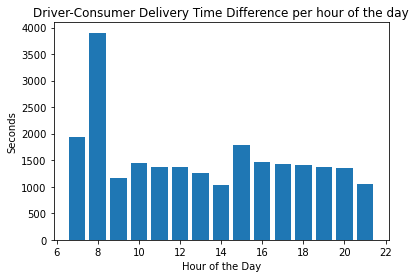

In [19]:
driver_consumer_timediff_per_hour = deliveries_data_is_asap_df.groupby('customer_order_hours').mean()['Driver-Consumer time diff']
print('Average driver-consumer delivery time difference from 7AM-8PM:', driver_consumer_timediff_per_hour.loc[7:21].mean(), 'seconds or',driver_consumer_timediff_per_hour.loc[7:21].mean()/60,'minutes')

plt.bar(driver_consumer_timediff_per_hour.index, driver_consumer_timediff_per_hour)
plt.title('Driver-Consumer Delivery Time Difference per hour of the day')
plt.ylabel('Seconds')
plt.xlabel('Hour of the Day')
plt.show()

In [20]:
start_hour, end_hour = 10, 20
average_total_time_order_receive = round(cust_merch_timediff_per_hour.loc[start_hour:end_hour].mean()/60 + merch_driver_timediff_per_hour.loc[start_hour:end_hour].mean()/60 + driver_consumer_timediff_per_hour.loc[start_hour:end_hour].mean()/60, 2)
print('Average total time for customers from ordering to receiving the orders during 10AM to 8PM is', average_total_time_order_receive, 'minutes')
print('')
print('From customers placing the orders until the merchants receiving the orders, there are average of',
      round(cust_merch_timediff_per_hour.loc[start_hour:end_hour].mean()/60, 2),'minutes of delay, which is about', 
      round(cust_merch_timediff_per_hour.loc[start_hour:end_hour].mean()/60/average_total_time_order_receive*100, 2),'% of average total time')
print('')
print('From merchants receiving the orders until the drivers arriving at the merchants, there are average of',
      round(merch_driver_timediff_per_hour.loc[start_hour:end_hour].mean()/60, 2),'minutes of delay, which is about', 
      round(merch_driver_timediff_per_hour.loc[start_hour:end_hour].mean()/60/average_total_time_order_receive*100, 2),'% of average total time')
print('')
print('From drivers arriving at the merchants until delivering the goods to the customers, there are average of',
      round(driver_consumer_timediff_per_hour.loc[start_hour:end_hour].mean()/60, 2),'minutes of delay, which is about', 
      round(driver_consumer_timediff_per_hour.loc[start_hour:end_hour].mean()/60/average_total_time_order_receive*100, 2),'% of average total time')

Average total time for customers from ordering to receiving the orders during 10AM to 8PM is 55.02 minutes

From customers placing the orders until the merchants receiving the orders, there are average of 6.63 minutes of delay, which is about 12.05 % of average total time

From merchants receiving the orders until the drivers arriving at the merchants, there are average of 25.18 minutes of delay, which is about 45.77 % of average total time

From drivers arriving at the merchants until delivering the goods to the customers, there are average of 23.2 minutes of delay, which is about 42.17 % of average total time


***Discussion***:
Looking at the average metrics computed above, there are significant improvements that could be made to expedite the total time from customers ordering and receiving the orders as well as each of the time-diff. 

Comparing this to the average 5 minutes drivers have to deliver maximum of 12 orders per hour at Palo Alto in Part D, the drivers take a total average of 23.2 minutes to deliver an order to a customer. I assume that when the drivers arrive at the merchants, the orders are ready at the merchants. This is almost 5 times slower than the expected average delivery time (23.2/5 = 4.64 times).

Some of the potential causes that I can think of are the following for each time-diff:

***Customer-Merchant Time Diff: ineffiency/delay at merchants***: 
 - Peak-hours: too many orders amd/or too little employees
 - Lack of training: not famiilar with the DoorDash platform

***Merchant-Driver Time Diff: inefficiency/delay at merchants and/or driver***:
 - Peak-hours: merchants are not finished with the food prep and the orders
 - Peak-hours traffic: Drivers are not ready to pick up food when food is ready at the merchants
 - Not enough drivers per toal order amount in region
 
***Driver-Consumer Time Diff: inefficiency/delay at driver***:
 - Peak-hours traffic
 - Too many places to deliver
 - Not enough drivers and cover long distances

In [21]:
# Perform linear regression
Y = deliveries_data[deliveries_data['Is ASAP']==True].groupby(['Delivery Region', 'customer_order_hours']).mean()['Merchant-Driver time diff'].values
X = np.vstack((deliveries_data[deliveries_data['Is ASAP']==True].groupby(['Delivery Region', 'customer_order_hours']).count().iloc[:, 0].values, 
                       deliveries_data[deliveries_data['Is ASAP']==True].groupby(['Delivery Region', 'customer_order_hours']).nunique()['Driver ID'].values)).T
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                 -0.025
Method:                 Least Squares   F-statistic:                    0.5651
Date:                Fri, 16 Jul 2021   Prob (F-statistic):              0.574
Time:                        16:51:00   Log-Likelihood:                -332.36
No. Observations:                  37   AIC:                             670.7
Df Residuals:                      34   BIC:                             675.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2374.1342    605.258      3.923      0.0

## Part F: Revenue Optimization

Perform data analysis to understand what features impact revenue, which is measured by 'Order total'. Assumption I make is that 'Order total' is the amount customers spend on the orders before discounts and tips.

### Discussion:
Looking at the 'Average Order total dollars for each restaurant' plot below, the average order total for each restaurant is estimated around 50 dollars, with the first standard deviation range from 40-60 dollars. Relatively, much less restaurants are getting orders that are more then 70 dollars and above. 

It is recommended to work with the merchants to increase their order total, which means shifting the bell curve in the plot below more to the right. This would provide a higher revenue to DoorDash while providing a win-win siutation to the merchants.

One interesting note is that providing discounts have very little to no impacts to the median value of order total value. It is recommended to perform A/B testing to understand how much discounts are needed to see a positive impact on the order total for each restaurant.

Amount of discount
False    38.630
True     38.595
Name: Order total, dtype: float64


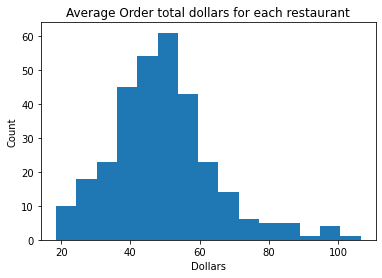

In [22]:
print(deliveries_data.groupby(deliveries_data['Amount of discount'] > 0).median()['Order total'])

rest_id_order_total = deliveries_data.groupby(['Restaurant ID']).mean()['Order total']
plt.hist(rest_id_order_total, bins=15)
plt.title('Average Order total dollars for each restaurant')
plt.ylabel('Count')
plt.xlabel('Dollars')
plt.show()

In [23]:
deliveries_data.groupby(deliveries_data['Is ASAP']).median()['Order total']

# Perform t-test
def t_test(test, control, tname, cname, var):
    pct_diff_ss = abs(control[var].count() - test[var].count())/float(control[var].count()) 
    pct_diff_var = abs(control[var].var() - control[var].var())/float(control[var].var())
    # if variance + sample sizes are within 20% use t-test
    if pct_diff_ss < .2 and pct_diff_var < .2:
        t, p = ss.ttest_ind(control[var], test[var], equal_var=True)
    # else use welch's t-test adaptation
    else: 
        t, p = ss.ttest_ind(control[var], test[var], equal_var=False)
    sigtext = "significant" if p<.05 else "not significant"
    return("The {diff}% difference in {var} ({tname} mean: {tmean}, {cname} mean: {cmean}) is {sigtext} (p={p})".format(var=var, tname=tname, cname=cname, tmean=round(test[var].mean(), 3), cmean=round(control[var].mean(), 3), 
                   diff=round((test[var].mean()-control[var].mean())/control[var].mean()*100, 3), sigtext=sigtext, p=round(p, 4)))
    
print(t_test(deliveries_data[deliveries_data['Is ASAP']==True], deliveries_data[deliveries_data['Is ASAP']==False], 'Is ASAP', 'Is not ASAP','Order total'))

The -41.723% difference in Order total (Is ASAP mean: 43.969, Is not ASAP mean: 75.448) is significant (p=0.0)


Using the t-test to compare the means of the two systems, on-demand orders (is ASAP=True) and scheduled orders (is ASAP=False), there is a significant difference in the mean values between the two as shown above. This is important for DoorDash and merchants to understand how can we incentive and encourage users to use scheduled orders more frequently.

Total time from customer placing the order to receiving order is significant to the amount of orders. As shown below, there is a 25.2% coorelation with a very low p-value. This is important to keep in mind as we are extracting insights from overall trends of all merchants. The majority of merchants have similar total time, but the goal of DoorDash is to work with the merchants to reduce the order time and maxmizing the experiences for everyone in the networks. Further recommendations and improvements are discussed in the business recommendations.

(0.25204826069322195, 5.495081254104488e-208)


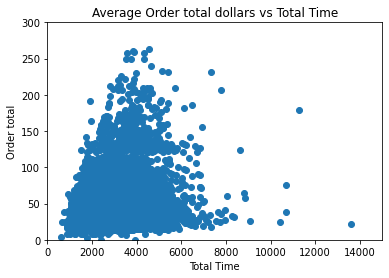

In [24]:
print(ss.pearsonr(deliveries_data_is_asap_df['total_time'],deliveries_data_is_asap_df['Order total']))
    
plt.scatter(deliveries_data_is_asap_df['total_time'],deliveries_data_is_asap_df['Order total'])
plt.xlim([0,15000])
plt.ylim([0,300])
plt.title('Average Order total dollars vs Total Time')
plt.ylabel('Order total')
plt.xlabel('Total Time')
plt.show()